## Angle correction to calculate total flux acorss shelf break wall

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb


In [3]:
CanyonGrid='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj

CanyonState='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

CanyonTracer='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/ptracersGlob.nc'

#FluxTH = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTHGlob.nc'
#FluxSLT = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxSLTGlob.nc'
FluxTR01 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTR01Glob.nc'
#FluxTR02 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTR02Glob.nc'
FluxOut = Dataset(FluxTR01)

#CanyonGridNoC='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/gridGlob.nc'
#CanyonGridOutNoC = Dataset(CanyonGridNoC)

#FluxTR01NoC = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/FluxTR01Glob.nc'
#FluxTR02NoC = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/FluxTR02Glob.nc'


In [4]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

#hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
#MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [5]:
sns.set()
sns.set_style('white')
sns.set_context('notebook')

### Tracer 1

In [6]:
VTRAC01 = rout.getField(FluxTR01,'VTRAC01') # 
UTRAC01 = rout.getField(FluxTR01,'UTRAC01') # 

In [7]:
import savitzky_golay as sg

In [8]:
zlev = 29
SBxx, SByy = sb.findShelfBreak(zlev,hFacC)
print(np.shape(SBxx))   
# 1. Find slope
deltaX = xc[SByy[8:],SBxx[8:]]-xc[SByy[:-8],SBxx[:-8]] # x2-x1
deltaY = yc[SByy[8:],SBxx[8:]]-yc[SByy[:-8],SBxx[:-8]] # y2-y1

#print (deltaY)
slope = deltaY/deltaX
xx = np.arange(360)

slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 51, polynomial order 3
# 2. Find angle
theta = np.arctan(slopeFilt)

# 3. get Tx, Ty (fluxSB)
VTRACPlot = sb.MerFluxSB(6,VTRAC01,z,xc,zlev,hFacC,MaskC)
UTRACPlot = sb.ZonFluxSB(6,UTRAC01,z,xc,zlev,hFacC,MaskC)

# 4. get components
TotTransport =  VTRACPlot[:,4:-4]*np.cos(theta) + UTRACPlot[:,4:-4]*np.sin(theta) 

# 5. add them up
print(np.shape(UTRACPlot[:,4:-4]*np.sin(theta)))   

(360,)
(90, 352)


(352,)


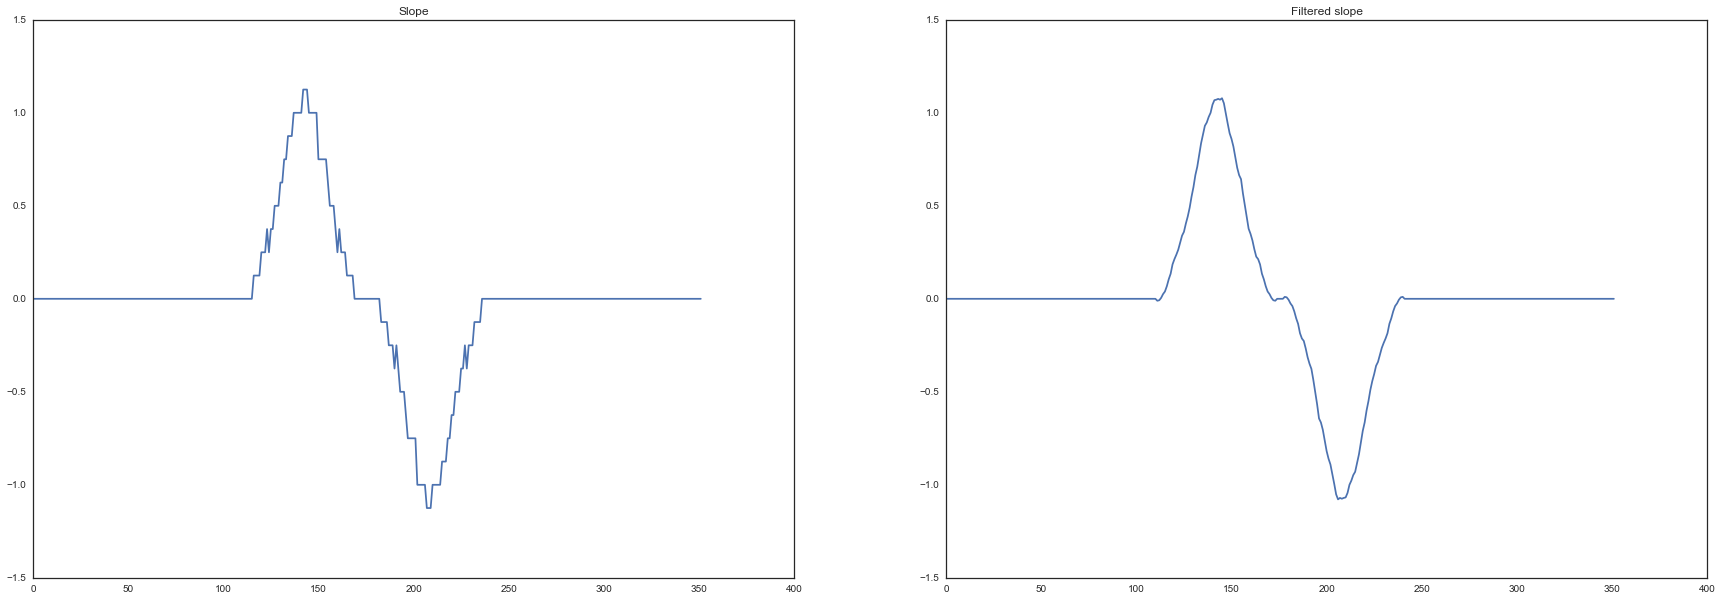

In [9]:
print(np.shape(slope))

figSize=(30,10)
numCols = 2
numRows = 1

fig44 = plt.figure(figsize=figSize)

plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(slope)
plt.title('Slope')

plt.subplot(numRows,numCols,2)
ax = plt.gca()
ax.plot(slopeFilt)
plt.title('Filtered slope')
 

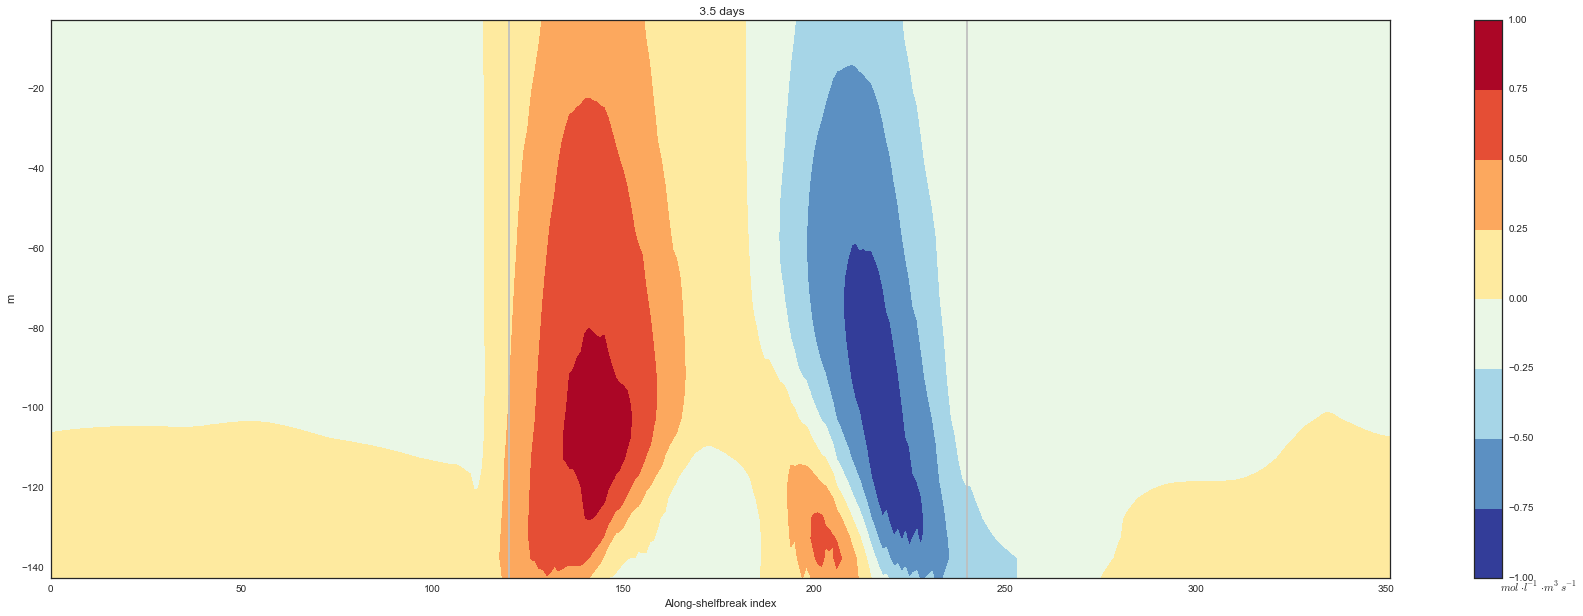

In [10]:
figSize=(30,10)
fig44 = plt.figure(figsize=figSize)
numCols = 1
numRows = 1
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'
sb.contourfFluxSB(6,numCols,numRows,TotTransport,z,xc,unitsTr, 0,29,1,zlev)

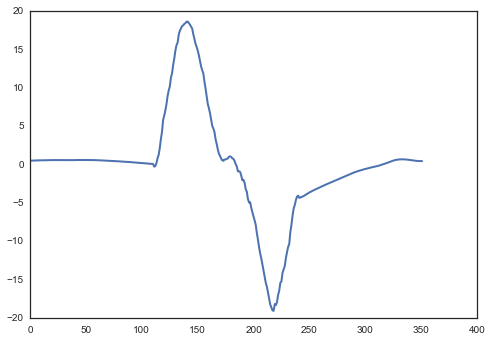

In [11]:
plt.plot(np.sum(TotTransport,axis=0),linewidth=2,label = (" %1.1f days " % ((6/2.)+0.5)))

(90, 360)


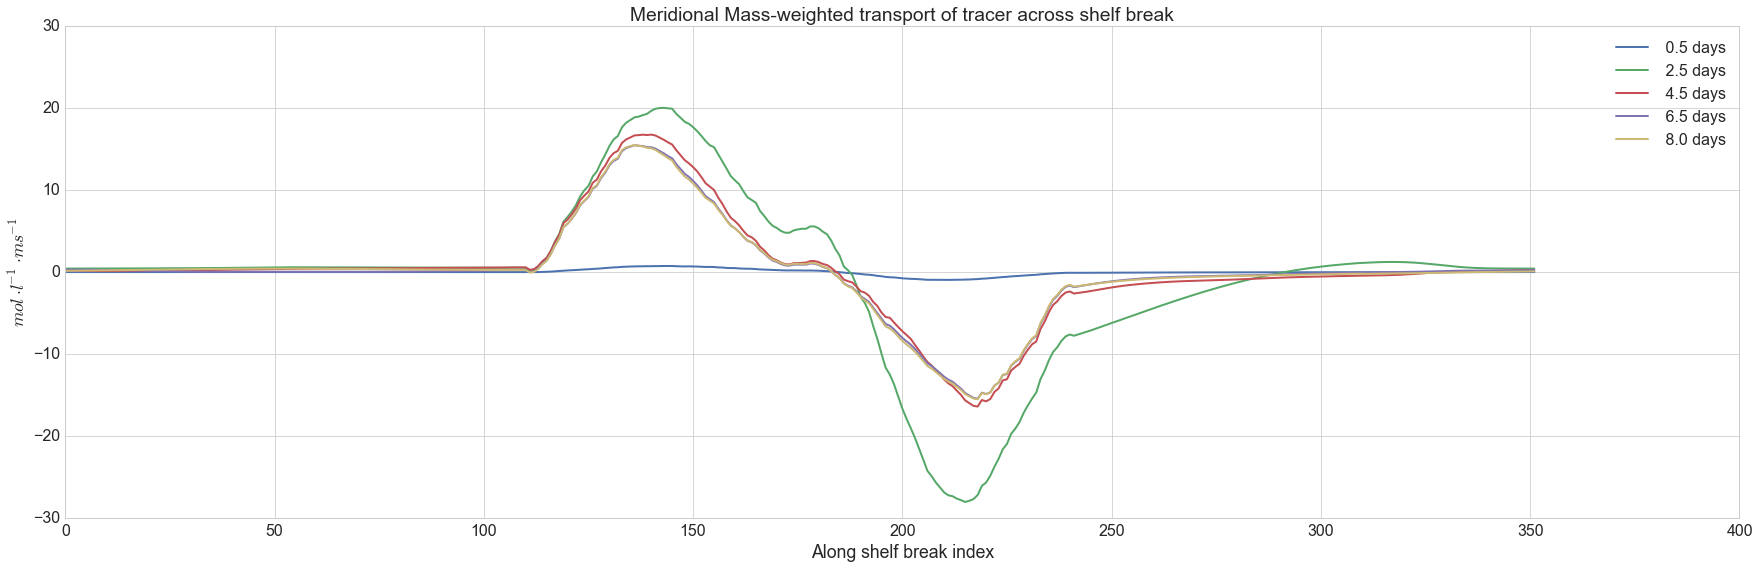

In [13]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 

figSize=(30,30)
numCols = 1
numRows = 3
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsTr2 = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'

areaSB = sb.AreaWallSB(hFacC,drF,dxF,zlev)
print(np.shape(areaSB))
kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    VPlot = sb.MerFluxSB(tt,VTRAC01,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(tt,UTRAC01,z,xc,zlev,hFacC,MaskC)
    
    TotTransport =  VPlot[:,4:-4]*np.cos(theta) + UPlot[:,4:-4]*np.sin(theta)
    
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(np.sum(TotTransport,axis=0),linewidth=2,label = (" %1.1f days " % ((tt/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Along shelf break index')
    plt.ylabel(unitsTr)
    plt.title('Meridional Mass-weighted transport of tracer across shelf break')
    
    

### NOTES
